<a href="https://colab.research.google.com/github/NavyaS26/Internship/blob/main/AutoEncoder_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)


In [4]:
noise_level = 0.45
x_train_noisy = x_train + noise_level * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_level * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [5]:
input_img = layers.Input(shape=(28, 28, 1))
e = layers.Conv2D(32, (3, 3), activation='swish', padding='same')(input_img)
e = layers.MaxPooling2D((2, 2), padding='same')(e)
e = layers.Conv2D(64, (3, 3), activation='swish', padding='same')(e)
encoded = layers.MaxPooling2D((2, 2), padding='same')(e)


In [6]:
d = layers.Conv2D(64, (3, 3), activation='swish', padding='same')(encoded)
d = layers.UpSampling2D((2, 2))(d)
d = layers.Conv2D(32, (3, 3), activation='swish', padding='same')(d)
d = layers.UpSampling2D((2, 2))(d)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d)


In [7]:
autoencoder = models.Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [9]:
stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=25,
    batch_size=128,
    shuffle=True,
    validation_split=0.1,
    callbacks=[stop]
)

Epoch 1/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 171s 406ms/step - loss: 0.3261 - val_loss: 0.3047
Epoch 2/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 172s 407ms/step - loss: 0.3008 - val_loss: 0.2992
Epoch 3/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 211s 428ms/step - loss: 0.2970 - val_loss: 0.2965
Epoch 4/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 197s 417ms/step - loss: 0.2937 - val_loss: 0.2943
Epoch 5/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 197s 405ms/step - loss: 0.2910 - val_loss: 0.2929
Epoch 6/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 203s 407ms/step - loss: 0.2896 - val_loss: 0.2907
Epoch 7/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 201s 404ms/step - loss: 0.2878 - val_loss: 0.2894
Epoch 8/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 171s 404ms/step - loss: 0.2869 - val_loss: 0.2889
Epoch 9/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 172s 406ms/step - loss: 0.2861 - val_loss: 0.2881
Epoch 10/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 170s 403ms/step - loss: 0.2856 - val_loss: 0.2877
Epoch 11/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 172s 407ms/step - loss: 0.2849 - val_loss: 0.2871
Epoch 12

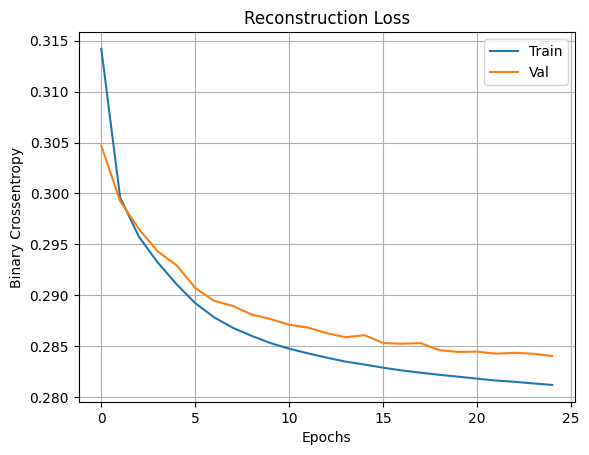

In [10]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.xlabel("Epochs")
plt.ylabel("Binary Crossentropy")
plt.title("Reconstruction Loss")
plt.legend()
plt.grid(True)
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


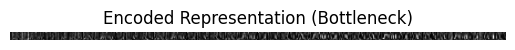

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step


In [13]:
encoder_model = models.Model(inputs=input_img, outputs=encoded)
encoded_imgs = encoder_model.predict(x_test_noisy)
plt.imshow(encoded_imgs[0].reshape(encoded_imgs.shape[1], -1), cmap='gray')
plt.title("Encoded Representation (Bottleneck)")
plt.axis("off")
plt.show()
decoded_imgs = autoencoder.predict(x_test_noisy)

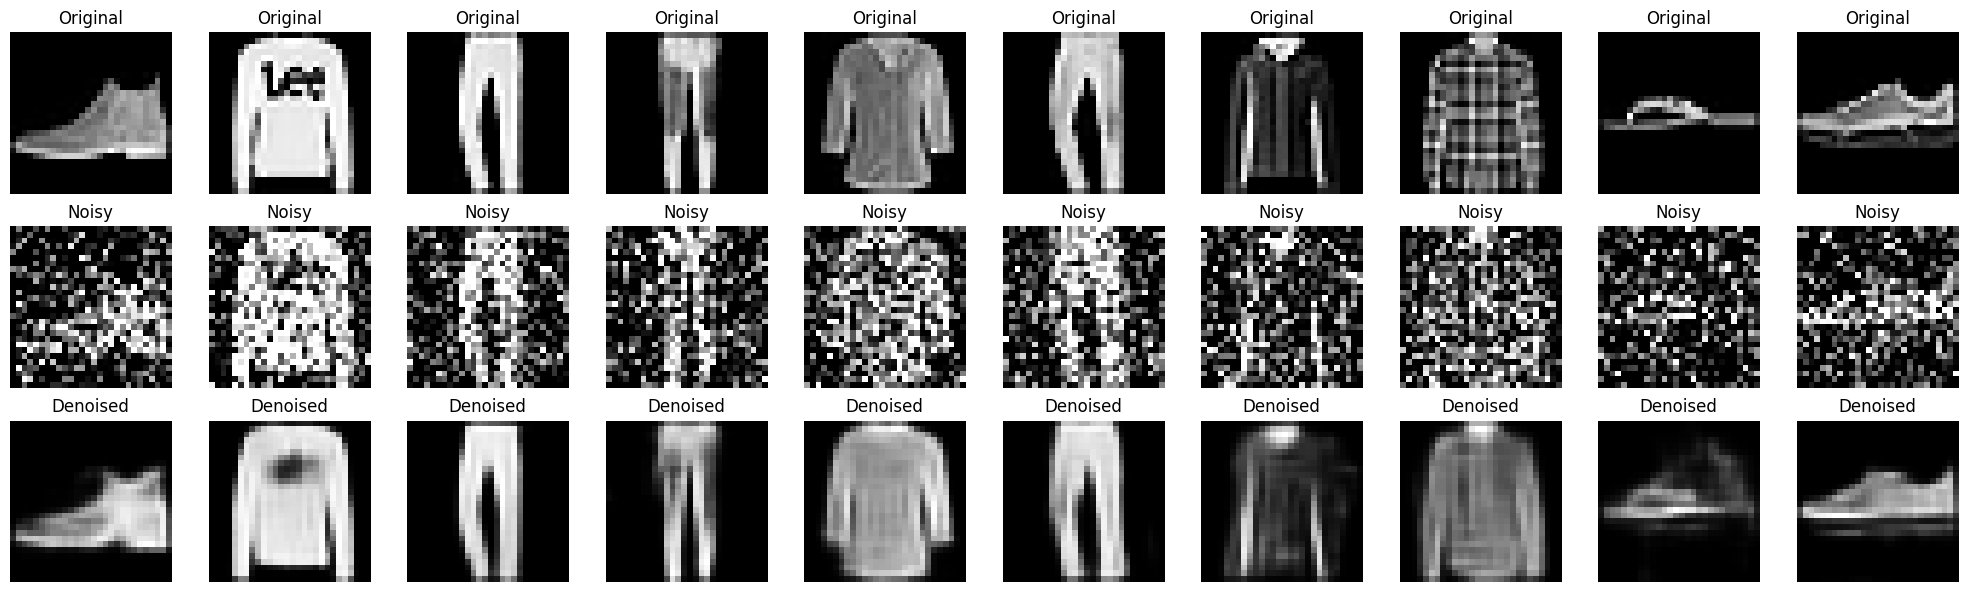

In [14]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')
plt.tight_layout()
plt.show()

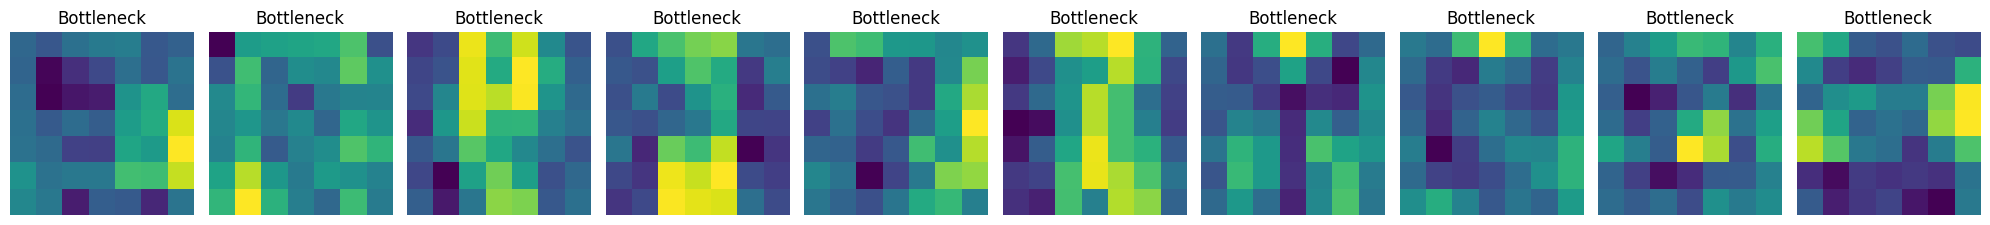

In [15]:

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    bottleneck_flat = np.mean(encoded_imgs[i], axis=-1)
    plt.imshow(bottleneck_flat, cmap='viridis')
    plt.title("Bottleneck")
    plt.axis('off')
plt.tight_layout()
plt.show()